In [1]:
import torch
from torch import nn

In [14]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
        )
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [2]:
conv_arch = ((1,64), (1,128), (2,256), (2,512), (2,512))

In [4]:
def vgg(conv_arch):
    conv_blocks =[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blocks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blocks,nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 10)
    )

In [36]:
vggnet = vgg(conv_arch)

In [24]:


def look_in_net(net, X):
    out = X
    
    for layer in net:
        out = layer(out)
        
        print(f"For Class name : {layer.__class__.__name__} shape: {out.shape}")

In [44]:
X = torch.randn(10, 1,224,224)

In [46]:
look_in_net(vggnet.cpu(), X)

For Class name : Sequential shape: torch.Size([10, 64, 112, 112])
For Class name : Sequential shape: torch.Size([10, 128, 56, 56])
For Class name : Sequential shape: torch.Size([10, 256, 28, 28])
For Class name : Sequential shape: torch.Size([10, 512, 14, 14])
For Class name : Sequential shape: torch.Size([10, 512, 7, 7])
For Class name : Flatten shape: torch.Size([10, 25088])
For Class name : Linear shape: torch.Size([10, 4096])
For Class name : ReLU shape: torch.Size([10, 4096])
For Class name : Dropout shape: torch.Size([10, 4096])
For Class name : Linear shape: torch.Size([10, 4096])
For Class name : ReLU shape: torch.Size([10, 4096])
For Class name : Dropout shape: torch.Size([10, 4096])
For Class name : Linear shape: torch.Size([10, 10])


In [40]:
device = torch.device('cuda')

In [31]:
from torchsummary import summary

In [41]:
vggnet_check = vggnet.to(device)
summary(vggnet_check, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [30]:
ratio = 16

small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch

[(1, 4), (1, 8), (2, 16), (2, 32), (2, 32)]

In [32]:
batch_size = 64

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

my_transforms = transforms.Compose(
                [
                 transforms.Resize(224),
                 transforms.ToTensor()
                ]
)

train_dataset = datasets.FashionMNIST(download=False, root="../../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../../data", train=False, transform=my_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [68]:
acc_arr = []

def train_net(net, num_epochs=3,lr=0.05):
    net = net
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    num_epochs = num_epochs
    
    acc_arr = []

    for epoch in range(num_epochs):
        acc_val = 0
        number = 0
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = ultra_small_net(X)
            l = criterion(pred, y)

            acc_val += accuracy(pred,y)
            number += len(y)

            optimizer.zero_grad()

            l.backward()

            optimizer.step()

        acc_arr.append(acc_val.detach().cpu()/number)
        print(f"Epoch {epoch} accuracy : {acc_arr[-1]}")
    

In [33]:
net = net
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 3

In [47]:
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1)==y).sum().float().mean()

In [51]:
ultra_small_net =vgg(small_conv_arch)

In [52]:
ultra_small_net = ultra_small_net.to(device)

In [53]:
summary(ultra_small_net, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              40
              ReLU-2          [-1, 4, 224, 224]               0
         MaxPool2d-3          [-1, 4, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]             296
              ReLU-5          [-1, 8, 112, 112]               0
         MaxPool2d-6            [-1, 8, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]           1,168
              ReLU-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 16, 56, 56]           2,320
             ReLU-10           [-1, 16, 56, 56]               0
        MaxPool2d-11           [-1, 16, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]           4,640
             ReLU-13           [-1, 32, 28, 28]               0
           Conv2d-14           [-1, 32,

In [54]:
%%time
acc_arr = []


for epoch in range(num_epochs):
    acc_val = 0
    number = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = ultra_small_net(X)
        l = criterion(pred, y)
        
        acc_val += accuracy(pred,y)
        number += len(y)
        
        optimizer.zero_grad()
        
        l.backward()
        
        optimizer.step()
    
        
    acc_arr.append(acc_val.detach().cpu()/number)
    print(f"Epoch {epoch} accuracy : {acc_arr[-1]}")

Epoch 0 accuracy : 0.10298333317041397
Epoch 1 accuracy : 0.09910000115633011
Epoch 2 accuracy : 0.09958333522081375
Wall time: 5min 16s


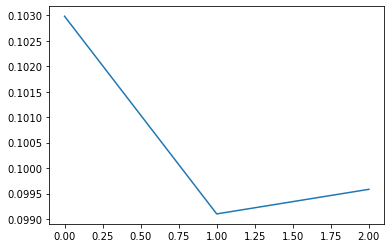

In [56]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), acc_arr)
plt.show()

In [57]:
acc_arr[-1]

tensor(0.0996)

In [60]:
ratio = 4

small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]

In [61]:
VGG_mini = vgg(small_conv_arch)

In [62]:
summary(VGG_mini.to(device),(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

In [64]:
def vgg_mini(conv_arch):
    conv_blocks =[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blocks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blocks,nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 512), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(512, 10)
    )

In [65]:
VGG_mini = vgg_mini(small_conv_arch)

In [66]:
summary(VGG_mini.to(device), (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

In [67]:
look_in_net(VGG_mini, X)

For Class name : Sequential shape: torch.Size([32, 16, 112, 112])
For Class name : Sequential shape: torch.Size([32, 32, 56, 56])
For Class name : Sequential shape: torch.Size([32, 64, 28, 28])
For Class name : Sequential shape: torch.Size([32, 128, 14, 14])
For Class name : Sequential shape: torch.Size([32, 128, 7, 7])
For Class name : Flatten shape: torch.Size([32, 6272])
For Class name : Linear shape: torch.Size([32, 512])
For Class name : ReLU shape: torch.Size([32, 512])
For Class name : Dropout shape: torch.Size([32, 512])
For Class name : Linear shape: torch.Size([32, 10])


In [70]:
%%time
train_net(VGG_mini, num_epochs=3, lr=0.005)

Epoch 0 accuracy : 0.0992666631937027
Epoch 1 accuracy : 0.09960000216960907
Epoch 2 accuracy : 0.09996666759252548
Wall time: 5min 19s


In [72]:
acc_arr

[]

In [74]:
plt.plot(range(num_epochs), acc_arr)
plt.imshow()

In [75]:
vgg_mini = vgg(small_conv_arch)

In [76]:
%%time

train_net(vgg_mini, num_epochs=3)

Epoch 0 accuracy : 0.0966000035405159
Epoch 1 accuracy : 0.09961666911840439
Epoch 2 accuracy : 0.10091666877269745
Wall time: 5min 11s


In [78]:
# print(acc_arr[-1])
# plt.plot(range(num_epochs), acc_arr)
# plt.imshow()